In [1]:
import litellm
from litellm import completion, completion_cost
from textwrap import dedent

In [2]:
# import os
# os.environ['LITELLM_LOG'] = 'DEBUG'

In [3]:
litellm.enable_cache(type="disk", disk_cache_dir="cache")

In [4]:
mini = "gpt-4o-mini"

In [5]:
response = completion(
  model=mini,
  messages=[{ "content": "Hello, how are you?","role": "user"}]
)

In [6]:
completion_cost(response)

1.995e-05

In [7]:
import base64

In [8]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [9]:
# Path to your image
image_path = "data/dog.jpeg"

# Getting the base64 string
base64_image = encode_image(image_path)

In [10]:
response = completion(
    model = mini, 
    messages=[
        {
            "role": "user",
            "content": [
                            {
                                "type": "text",
                                "text": "What’s in this image?"
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                                "detail": "low"
                                }
                            }
                        ]
        }
    ],
    temperature=0,
    caching=True
)

In [11]:
print(response.choices[0].message.content)

The image features a golden retriever puppy sitting on grass, surrounded by fallen leaves. The puppy appears happy and playful, with a bright expression.


In [12]:
completion_cost(response)

0.00044429999999999996

# JSON

In [13]:
import json

def generate_json_schema_from_df(df_format, schema_name):
    """
    Generates a JSON schema from a DataFrame format with a specified schema name,
    encouraging the model to output multiple rows as an array of objects within an object.
    
    Parameters:
    df_format (pd.DataFrame): A DataFrame with 'column_name' and 'type' columns.
    schema_name (str): The name of the schema.

    Returns:
    dict: A JSON schema based on the input DataFrame format.
    """
    # Define the schema with an object containing an array of objects
    schema = {
        "name": schema_name,
        "schema": {
            "type": "object",
            "properties": {
                "data": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {},
                        "required": [],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["data"],
            "additionalProperties": False
        },
        "strict": True
    }

    for _, row in df_format.iterrows():
        column_name = row['column_name']
        col_type = row['type']
        
        # Map the DataFrame type to JSON schema types
        if col_type.lower() in ['int', 'integer']:
            json_type = "integer"
        elif col_type.lower() in ['float', 'double', 'number']:
            json_type = "number"
        elif col_type.lower() in ['bool', 'boolean']:
            json_type = "boolean"
        elif col_type.lower() in ['object', 'string', 'text']:
            json_type = "string"
        elif col_type.lower() in ['list', 'array']:
            json_type = "array"
            # Specify the type of items in the array (for this example, assume array of strings)
            schema['schema']['properties']['data']['items']['properties'][column_name] = {
                "type": "array",
                "items": {"type": "string"}
            }
            schema['schema']['properties']['data']['items']['required'].append(column_name)
            continue  # Skip the default addition below for arrays
        else:
            json_type = "string"  # default fallback type

        # Add the column to the schema
        schema['schema']['properties']['data']['items']['properties'][column_name] = {"type": json_type}
        schema['schema']['properties']['data']['items']['required'].append(column_name)

    return schema

In [14]:
# Example usage
import pandas as pd

# Creating a sample DataFrame format
data = {
    'column_name': ['id', 'username', 'email', 'age', 'is_active', 'signup_date', 'preferences'],
    'type': ['int', 'string', 'string', 'int', 'bool', 'string', 'array']
}

df_format = pd.DataFrame(data)

# Generate the JSON schema
schema_name = "user_data_schema"
json_schema = generate_json_schema_from_df(df_format, schema_name)

In [15]:
query = """| id  | username  | email               | age | is_active | signup_date | preferences            |
|-----|-----------|---------------------|-----|-----------|-------------|------------------------|
| 1   | user1     | user1@example.com    | 25  | True      | 2024-08-01  | ["sports", "music"]    |
| 2   | user2     | user2@example.com    | 30  | False     | 2024-07-21  |   |
| 3   | user3     | NULL                 | 22  | True      | NULL        | ["gaming", "cooking"]  |
| 4   | NULL      | user4@example.com    | 28  | NULL      | 2024-08-05  | NULL                   |
| 5   | user5     | NULL                 | NULL| False     | 2024-07-30  | ["fitness", "technology"] |
"""


In [35]:
response = completion(
    model="gpt-4o-2024-08-06",
    messages=[
        {
            "role": "system", 
            "content": "convert the markdown dataframe into the provided schema, empty cells or NA cells should be Nulls"
        },
        {
            "role": "user", 
            "content": query
        }
    ],
    response_format={
        "type": "json_schema",
        "json_schema": json_schema
    },
    temperature=0,
)

08:05:51 - LiteLLM:WARNING: utils.py:357 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.




Request to litellm:
litellm.completion(model='gpt-4o-2024-08-06', messages=[{'role': 'system', 'content': 'convert the markdown dataframe into the provided schema, empty cells or NA cells should be Nulls'}, {'role': 'user', 'content': '| id  | username  | email               | age | is_active | signup_date | preferences            |\n|-----|-----------|---------------------|-----|-----------|-------------|------------------------|\n| 1   | user1     | user1@example.com    | 25  | True      | 2024-08-01  | ["sports", "music"]    |\n| 2   | user2     | user2@example.com    | 30  | False     | 2024-07-21  |   |\n| 3   | user3     | NULL                 | 22  | True      | NULL        | ["gaming", "cooking"]  |\n| 4   | NULL      | user4@example.com    | 28  | NULL      | 2024-08-05  | NULL                   |\n| 5   | user5     | NULL                 | NULL| False     | 2024-07-30  | ["fitness", "technology"] |\n'}], response_format={'type': 'json_schema', 'json_schema': {'name': 'user_

In [17]:
base64_image = encode_image("data/table.png")

In [18]:
image = {
    "type": "image_url",
    "image_url": {
        "url": f"data:image/png;base64,{base64_image}",
        "detail": "low"
    }
}

08:06:25 - LiteLLM:WARNING: utils.py:357 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.




Request to litellm:
litellm.completion(model='gpt-4o-2024-08-06', messages=[{'role': 'system', 'content': 'convert the markdown dataframe into the provided schema, empty cells or NA cells should be Nulls'}, {'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': '', 'detail': 'low'}}]}], response_format={'type': 'json_schema', 'json_schema': {'name': 'user_data_schema', 'schema': {'type': 'object', 'properties': {'data': {'type': 'array', 'items': {'type': 'object', 'properties': {'id': {'type': 'integer'}, 'username': {'type': 'string'}, 'email': {'type': 'string'}, 'age': {'type': 'integer'}, 'is_active': {'type': 'boolean'}, 'signup_date': {'type': 'string'}, 'preferences': {'type': 'array', 'items': {'type': 'string'}}}, 'required': ['id', 'username', 'email', 'age', 'is_active', 'signup_date', 'preferences'], 'additionalProperties': False}}}, 'required': ['data'], 'additionalProperties': False}, 'strict': True}}, temperature=0, max_tokens=1024)


SYNC kwargs[cach
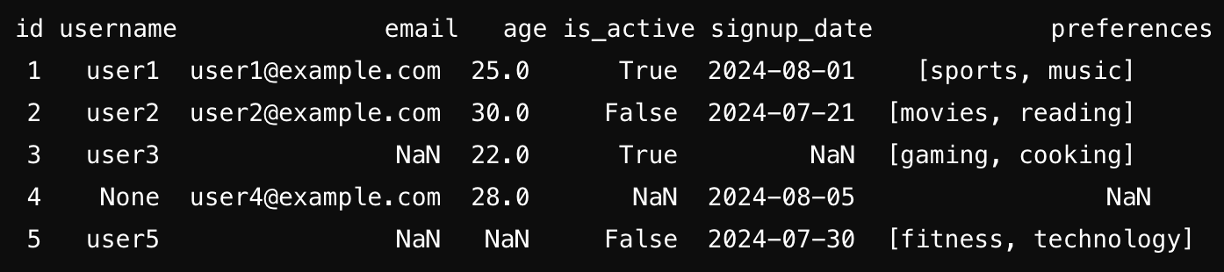
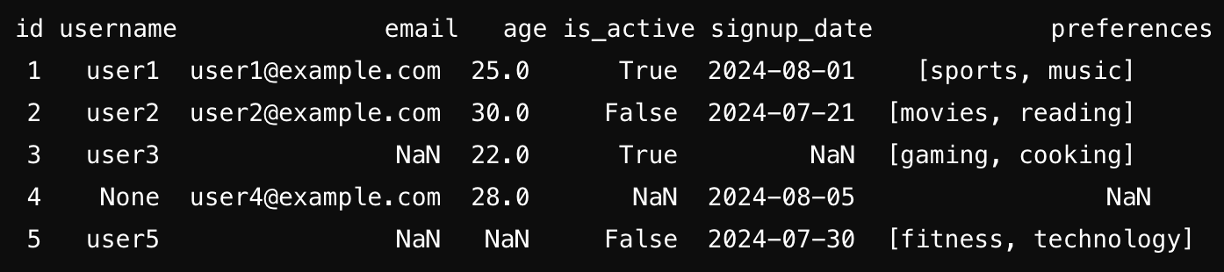
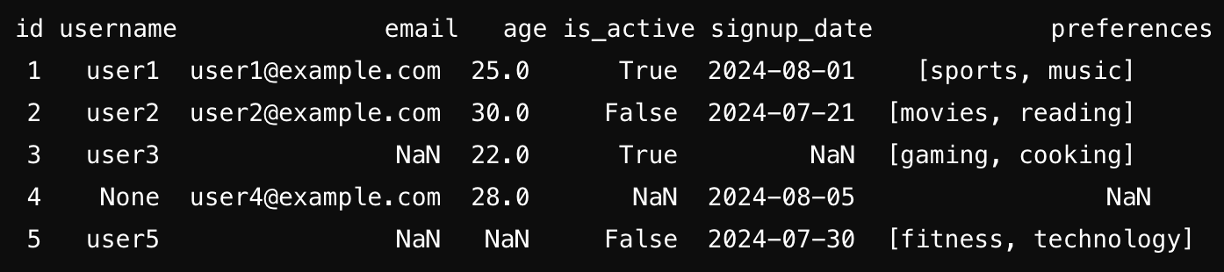
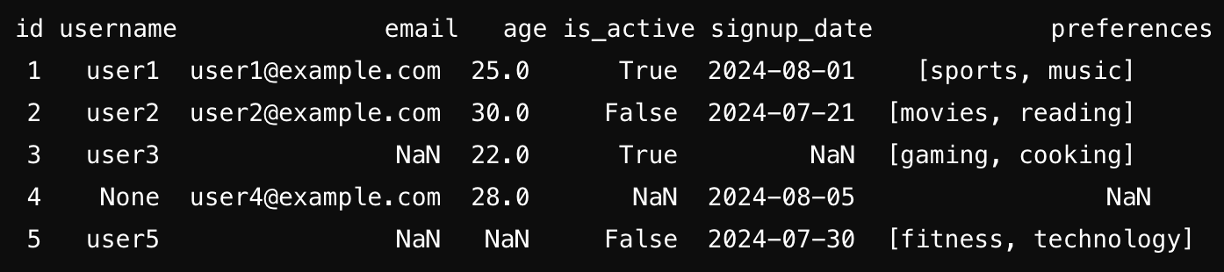
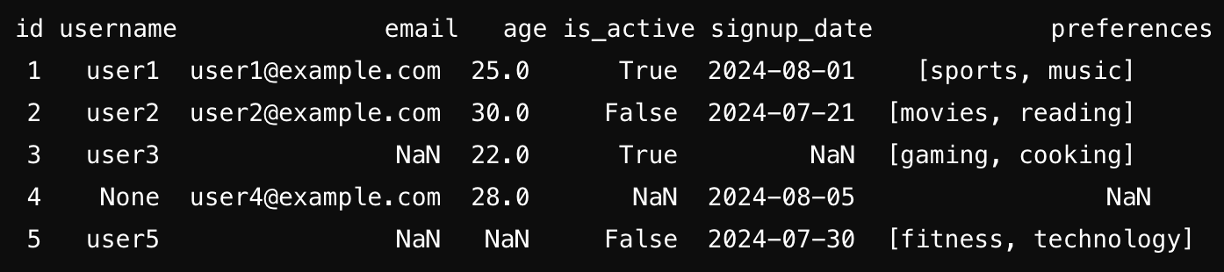
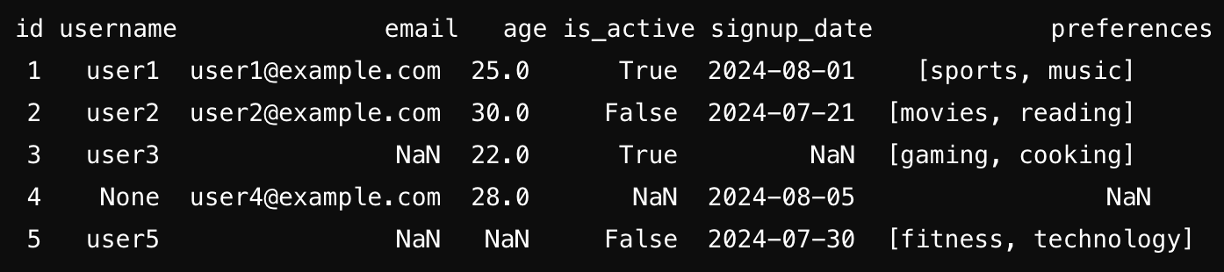
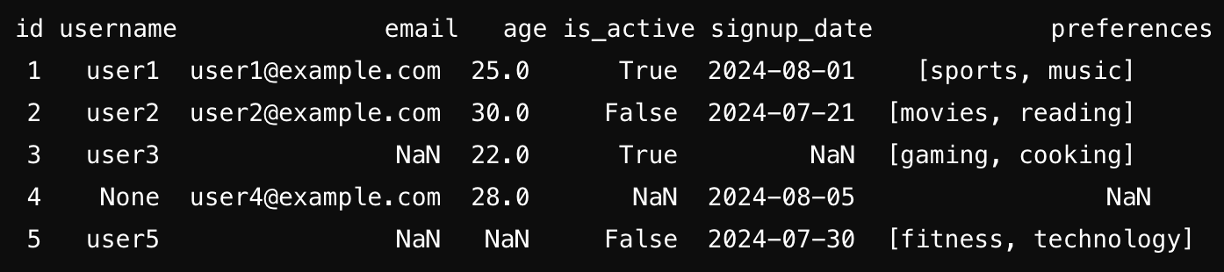
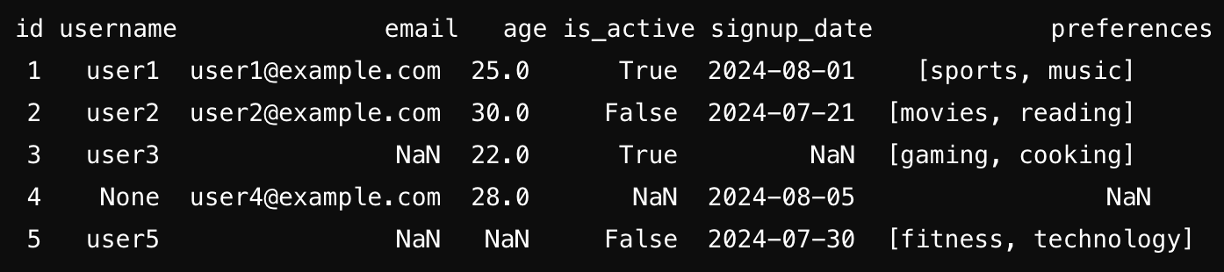

In [36]:
response = completion(
    model="gpt-4o-2024-08-06",
    messages=[
        {
            "role": "system", 
            "content": "convert the markdown dataframe into the provided schema, empty cells or NA cells should be Nulls"
        },
        {
            "role": "user", 
            "content": [image]
        }
    ],
    response_format={
        "type": "json_schema",
        "json_schema": json_schema
    },
    temperature=0,
    max_tokens=1024
)

In [37]:
response_content = response.choices[0].message.content

In [38]:
df = pd.DataFrame(json.loads(response_content)['data'])

In [39]:
df

,id,username,email,age,is_active,signup_date,preferences
0,1,user1,user1@example.com,25,True,2024-08-01,"[sports, music]"
1,2,user2,user2@example.com,30,False,2024-07-21,"[movies, reading]"
2,3,user3,NaN,22,True,2024-08-11,"[gaming, cooking]"
3,4,None,user4@example.com,28,True,2024-08-05,[]
4,5,user5,NaN,32,False,2024-07-30,"[fitness, technology]"


# Anthropic

In [ ]:
import fitz

def pdf_to_base64_pngs(pdf_path, pages=None, quality=75, max_size=(1024, 1024)):
    # Open the PDF file
    doc = fitz.open(pdf_path)

    # Iterate through each page of the PDF
    if pages is None:
        pages = range(doc.page_count)

    for page_num in pages:
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Save the PNG image
        output_path = f"../images/reading_charts_graphs/slides/page_{page_num+1}.png"
        pix.save(output_path)

    # Convert the PNG images to base64 encoded strings
    images = [Image.open(f"../images/reading_charts_graphs/slides/page_{page_num+1}.png") for page_num in range(doc.page_count)]
    # Close the PDF document
    doc.close()

    base64_encoded_pngs = []

    for image in images:
        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
            
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

    return base64_encoded_pngs

In [23]:
litellm.set_verbose=True

07:58:50 - LiteLLM:WARNING: utils.py:357 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.




Request to litellm:
litellm.completion(model='claude-3-5-sonnet-20240620', messages=[{'role': 'system', 'content': "convert the markdown dataframe into the provided schema, empty cells or NA cells should be Nulls: {'name': 'user_data_schema', 'schema': {'type': 'object', 'properties': {'data': {'type': 'array', 'items': {'type': 'object', 'properties': {'id': {'type': 'integer'}, 'username': {'type': 'string'}, 'email': {'type': 'string'}, 'age': {'type': 'integer'}, 'is_active': {'type': 'boolean'}, 'signup_date': {'type': 'string'}, 'preferences': {'type': 'array', 'items': {'type': 'string'}}}, 'required': ['id', 'username', 'email', 'age', 'is_active', 'signup_date', 'preferences'], 'additionalProperties': False}}}, 'required': ['data'], 'additionalProperties': False}, 'strict': True}"}, {'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': '', 'detail': 'low'}}]}, {'role': 'assistant', 'content': 'Here is the JSON requested:\n{', 'prefix': True}], temperature=0
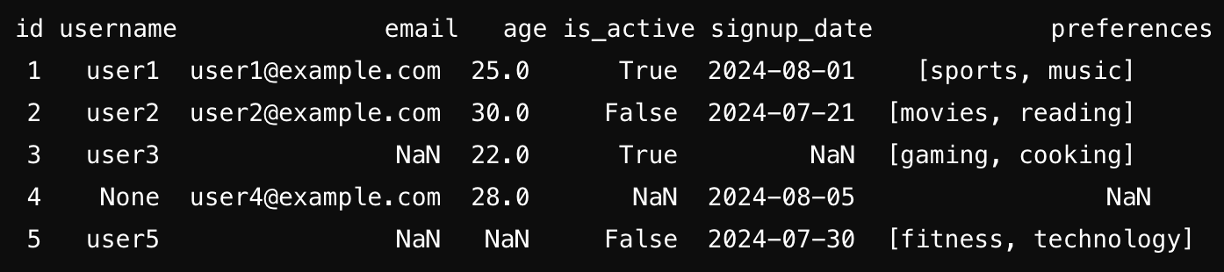
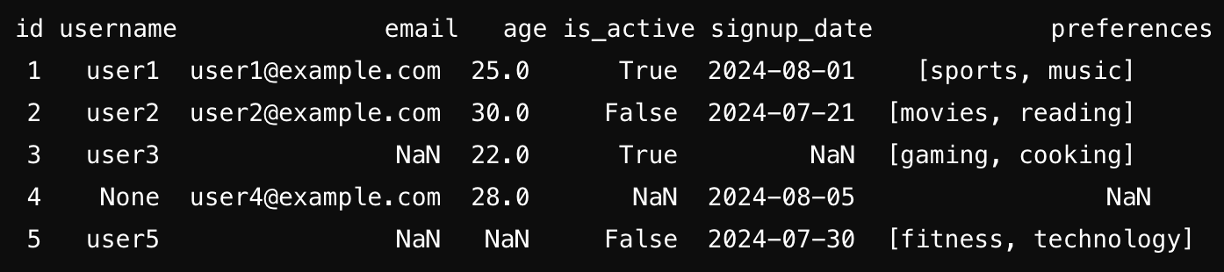
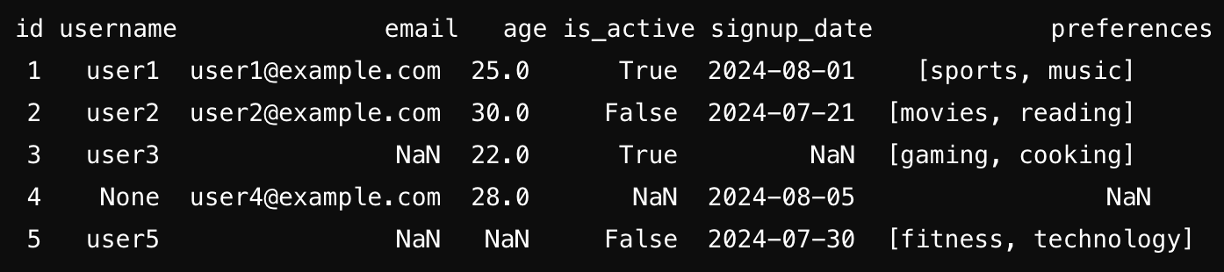
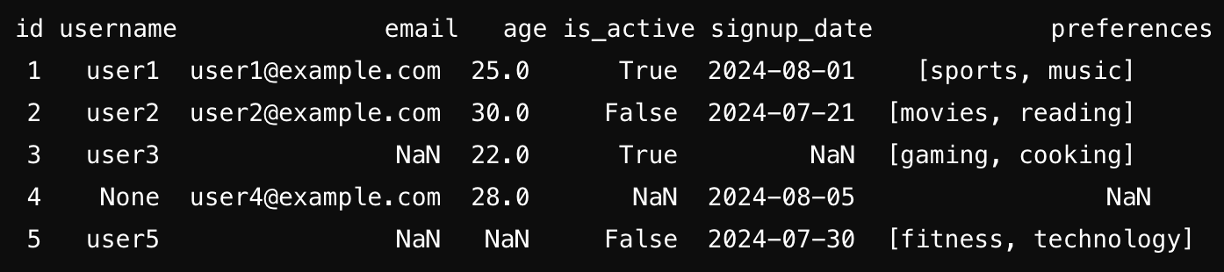
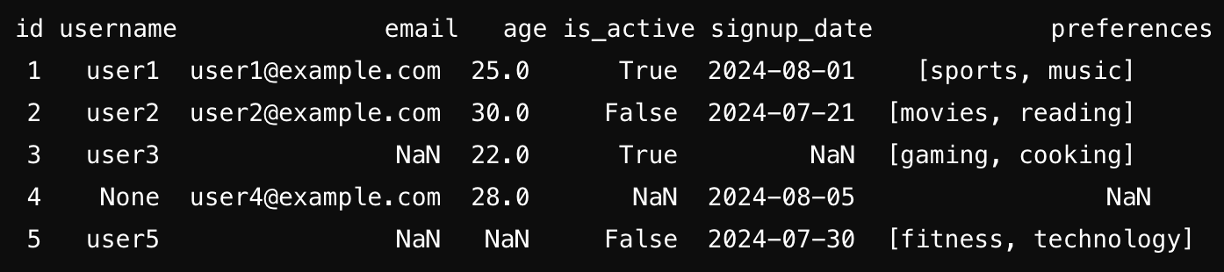
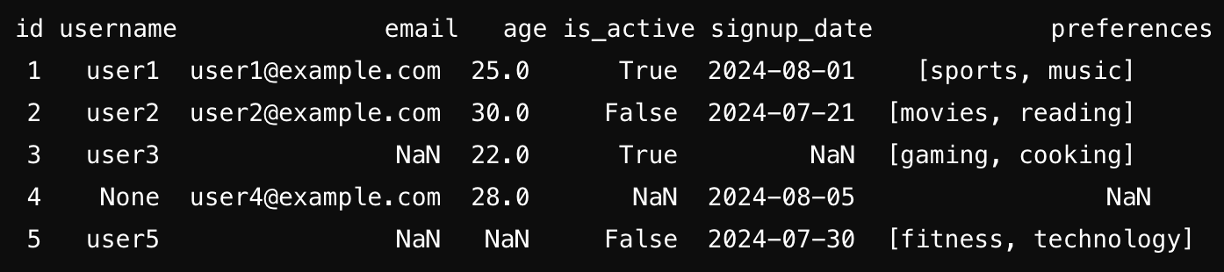
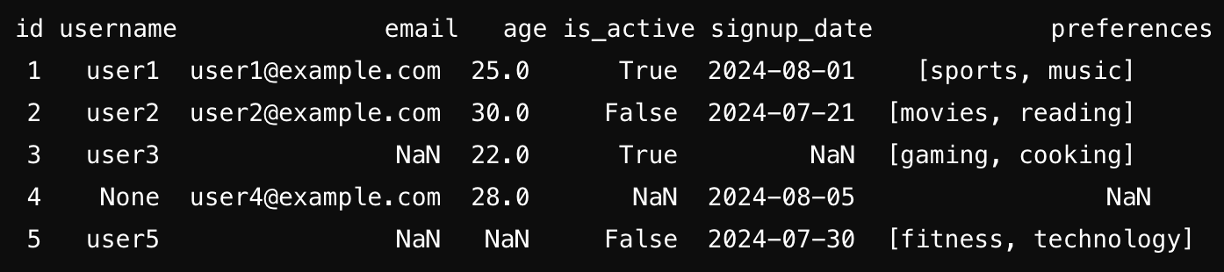

In [29]:
response = completion(
    model="claude-3-5-sonnet-20240620",
    messages=[
        {
            "role": "system", 
            "content": f"convert the markdown dataframe into the provided schema, empty cells or NA cells should be Nulls: {json_schema}"
        },
        {
            "role": "user", 
            "content": [image]
        },
        {
            "role": "assistant",
            "content": "Here is the JSON requested:\n{",
            "prefix": True
        }
    ],
    temperature=0,
    max_tokens=1024
)

In [30]:
response_content = "{" + response.choices[0].message.content

In [32]:
completion_cost(response)

Looking up model=claude-3-5-sonnet-20240620 in model_cost_map
Success: model=claude-3-5-sonnet-20240620 in model_cost_map
prompt_tokens=694; completion_tokens=383
Returned custom cost for model=claude-3-5-sonnet-20240620 - prompt_tokens_cost_usd_dollar: 0.002082, completion_tokens_cost_usd_dollar: 0.005745


0.007827

In [33]:
df2 = pd.DataFrame(json.loads(response_content)['data'])

In [ ]:
df2

,id,username,email,age,is_active,signup_date,preferences
0,1,user1,user1@example.com,25,True,2024-08-01,"[sports, music]"
1,2,user2,user2@example.com,30,False,2024-07-21,"[movies, reading]"
2,3,user3,,22,True,,"[gaming, cooking]"
3,4,,user4@example.com,28,False,2024-08-05,[]
4,5,user5,,0,False,2024-07-30,"[fitness, technology]"


In [28]:
df

,id,username,email,age,is_active,signup_date,preferences
0,1,user1,user1@example.com,25,True,2024-08-01,"[sports, music]"
1,2,user2,user2@example.com,30,False,2024-07-21,"[movies, reading]"
2,3,user3,,22,True,2024-08-11,"[gaming, cooking]"
3,4,,user4@example.com,28,True,2024-08-05,[]
4,5,user5,,32,False,2024-07-30,"[fitness, technology]"
